In [2]:
# required libs
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
import random
import time
import numpy as np

class SimpleGridEnv25_Complex:
    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.size = 25
        self.center = (12, 12)
        self.goal = self.center
        # Teleporters (fixed coords) and their probability tuples: (p_goal, p_enemy, p_random)
        self.teleporters = {
            (0, 12): (0.4, 0.3, 0.3),   # top center — biased to goal
            (12, 0): (0.2, 0.5, 0.3),   # left center — biased to enemy
            (24, 12): (0.1, 0.2, 0.7),  # bottom center — mostly random
        }

        # Stochastic transition model: intended action -> list of (move_name, prob)
        # Move names: 'up','down','left','right','stay'
        self.action_transitions = {
            0: [('up', 1)],
            1: [('down', 1)],  # down
            2: [('left', 1)],     # left
            3: [('right',1)],    # right
        }

        # Wall radii as requested (Option A spacing)
        self.inner_wall_radius = 4
        self.outer_wall_radius = 8

        # Enemy radii as requested (Preset 1)
        self.enemy_radii = [3, 5, 7]

        # Build enemy paths
        self.enemy_paths = [self._diamond_path(r) for r in self.enemy_radii]

        # Build wall rings with 4 cardinal holes each
        self.walls = set()
        self._build_wall_rings_with_cardinal_holes()

        # initialize
        self.reset()

    def _diamond_path(self, radius):
        """Return Manhattan diamond loop of given radius in clockwise order around self.center."""
        cx, cy = self.center
        pts = []
        for i in range(radius + 1):
            pts.append((cx + i, cy + (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx + (radius - i), cy - i))
        for i in range(1, radius + 1):
            pts.append((cx - i, cy - (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx - (radius - i), cy + i))
        return pts

    def _diamond_coords(self, r):
        """Return all coords exactly at Manhattan distance r from center."""
        cx, cy = self.center
        coords = []
        for x in range(self.size):
            for y in range(self.size):
                if abs(x - cx) + abs(y - cy) == r:
                    coords.append((x, y))
        coords.sort()
        return coords

    def _build_wall_rings_with_cardinal_holes(self):
        """Create inner and outer diamond rings; carve 4 cardinal holes on each ring."""
        cx, cy = self.center

        inner = set(self._diamond_coords(self.inner_wall_radius))
        outer = set(self._diamond_coords(self.outer_wall_radius))

        # 4 cardinal holes each: top, right, bottom, left
        inner_holes = {
            (cx, cy + self.inner_wall_radius),
            (cx + self.inner_wall_radius, cy),
            (cx, cy - self.inner_wall_radius),
            (cx - self.inner_wall_radius, cy)
        }
        outer_holes = {
            (cx, cy + self.outer_wall_radius),
            (cx + self.outer_wall_radius, cy),
            (cx, cy - self.outer_wall_radius),
            (cx - self.outer_wall_radius, cy)
        }

        for h in inner_holes:
            inner.discard(h)
        for h in outer_holes:
            outer.discard(h)

        self.walls = inner.union(outer)

        # Ensure teleporters and goal aren't walls
        for t in self.teleporters.keys():
            self.walls.discard(t)
        self.walls.discard(self.goal)

    def reset(self):
        corners = [(0, 0), (0, self.size - 1), (self.size - 1, 0), (self.size - 1, self.size - 1)]
        self.agent = random.choice(corners)
        # enemy indices staggered so enemies are spaced around their loops
        self.e_idx = []
        for pth in self.enemy_paths:
            # pick indices spaced apart so they start at different positions
            # use offsets: 0, len/3, 2*len/3 (rounded)
            L = len(pth)
            if L == 0:
                self.e_idx.append(0)
            else:
                # small random offset to avoid perfect sync across runs
                self.e_idx.append((len(self.e_idx) * (L // 3)) % L)
        self.enemies = [pth[idx % len(pth)] for pth, idx in zip(self.enemy_paths, self.e_idx)]
        return self.state()

    def state(self):
        ax, ay = self.agent
        return (
            ax, ay,
            self.enemies[0][0], self.enemies[0][1],
            self.enemies[1][0], self.enemies[1][1],
            self.enemies[2][0], self.enemies[2][1],
        )

    def _sample_actual_move(self, intended):
        dist = self.action_transitions[intended]
        r = random.random()
        cum = 0.0
        for mv, p in dist:
            cum += p
            if r <= cum:
                return mv
        return dist[-1][0]

    def _apply_move(self, pos, move):
        x, y = pos
        if move == 'up':
            x -= 1
        elif move == 'down':
            x += 1
        elif move == 'left':
            y -= 1
        elif move == 'right':
            y += 1
        elif move == 'stay':
            pass
        # bounds
        x = max(0, min(self.size - 1, x))
        y = max(0, min(self.size - 1, y))
        return (x, y)

    def _teleport_from(self, tele_pos):
        gp, ep, rp = self.teleporters[tele_pos]
        r = random.random()
        if r < gp:
            return self.goal
        elif r < gp + ep:
            # choose a current enemy uniformly
            return random.choice(self.enemies)
        else:
            # random empty cell (avoid walls for fairness)
            attempts = 0
            while True:
                x = random.randint(0, self.size - 1)
                y = random.randint(0, self.size - 1)
                if (x, y) not in self.walls:
                    return (x, y)
                attempts += 1
                if attempts > 1000:
                    # fallback
                    return (x, y)

    def _move_enemies(self):
        new = []
        for i, pth in enumerate(self.enemy_paths):
            if len(pth) == 0:
                new.append(self.enemies[i])
                continue
            self.e_idx[i] = (self.e_idx[i] + 1) % len(pth)
            new.append(pth[self.e_idx[i]])
        self.enemies = new

    def step(self, action):
        """
        :param action: int 0..3
        :returns: state, reward, done, info
        """
        # 1) sample actual move
        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)

        # 2) walls block movement (unless candidate is a hole)
        if candidate in self.walls:
            # blocked -> stay
            next_agent = self.agent
        else:
            next_agent = candidate

        self.agent = next_agent

        # 3) teleporters
        if self.agent in self.teleporters:
            self.agent = self._teleport_from(self.agent)

        # 4) move enemies
        self._move_enemies()

        # 5) reward & terminal
        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif self.agent in self.enemies:
            reward = -200
            done = True

        return self.state(), reward, done, {}

    def ascii_render(self):
        """Compact 25x25 rendering with single-character map:
        '.' empty, 'W' wall, 'T' teleporter, 'G' goal, 'A' agent, '1','2','3' enemies.
        Rows printed top-to-bottom (0..24).
        """
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]

        # walls
        for (x, y) in self.walls:
            grid[x][y] = 'W'
        # teleporters
        for t in self.teleporters.keys():
            tx, ty = t
            grid[tx][ty] = 'T'
        # goal
        gx, gy = self.goal
        grid[gx][gy] = 'G'
        # enemies
        for i, (ex, ey) in enumerate(self.enemies):
            ch = str((i + 1) % 10)
            grid[ex][ey] = ch
        # agent (override)
        ax, ay = self.agent
        grid[ax][ay] = 'A'

        # print header index row (mod10) for columns
        header = '   ' + ''.join(str(j % 10) for j in range(self.size))
        print(header)
        for i, row in enumerate(grid):
            # left index (mod10) and row content
            print(f'{i % 10:>2} ' + ''.join(row))
        print('-' * (self.size + 4))

    def free_cells(self):
        cells = []
        for x in range(self.size):
            for y in range(self.size):
                if (x, y) not in self.walls and (x, y) not in self.teleporters and (x, y) != self.goal:
                    cells.append((x, y))
        return cells

In [4]:
class EnhancedComplexGridEnv(SimpleGridEnv25_Complex):
    """
    Enhanced version with behavior tracking for analysis
    """
    def __init__(self, seed=None):
        super().__init__(seed)

    def step(self, action):
        """
        Enhanced step with behavior tracking
        """
        old_agent = self.agent
        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)
        wall_collision = False
        if candidate in self.walls:
            next_agent = self.agent
            wall_collision = True
        else:
            next_agent = candidate
        self.agent = next_agent
        teleported = False
        if self.agent in self.teleporters:
            old_pos = self.agent
            self.agent = self._teleport_from(self.agent)
            teleported = (old_pos != self.agent)
        self._move_enemies()
        near_enemy = self._check_near_enemy()
        enemy_collision = self.agent in self.enemies
        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif enemy_collision:
            reward = -200
            done = True
        info = {
            'wall_collision': wall_collision,
            'enemy_collision': enemy_collision,
            'near_enemy': near_enemy,
            'teleported': teleported,
            'actual_move': actual_move
        }

        return self.state(), reward, done, info
    def _check_near_enemy(self):
        """Check if agent is within 2 steps of any enemy"""
        ax, ay = self.agent
        for enemy in self.enemies:
            ex, ey = enemy
            distance = abs(ax - ex) + abs(ay - ey)  # Manhattan distance
            if distance <= 2:
                return True
        return False

In [ ]:
print()

[0, 0, 0, 1, 0, 0]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque, namedtuple

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STATE_DIM = 8
N_ACTIONS = 4

# --- TRAINING PARAMETERS ---
MAX_TRAIN_STEPS = 100000
MAX_EPISODE_STEPS = 150
TRAIN_START = 1500
BUFFER_CAPACITY = 50000
BATCH_SIZE = 128

GAMMA = 0.99
LR = 5e-4

# --- EXPLORATION ---
EPS_START = 1.0
EPS_END = 0.10
EPS_DECAY = 0.9999

# --- TARGET NETWORK UPDATE ---
TARGET_UPDATE_FREQ = 1500

EVAL_EVERY = 5000
EVAL_EPISODES = 5


class QNet(nn.Module):
    def __init__(self, input_dim=STATE_DIM, hidden=256, output_dim=N_ACTIONS):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
Transition = namedtuple('Transition', ('s', 'a', 'r', 's2', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=BUFFER_CAPACITY):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done):
        self.buf.append(Transition(s, a, r, s2, done))

    def sample(self, batch_size):
      batch = random.sample(self.buf, batch_size)

      s  = torch.from_numpy(np.array([t.s   for t in batch], dtype=np.float32)).to(DEVICE)
      a  = torch.from_numpy(np.array([t.a   for t in batch], dtype=np.int64)).to(DEVICE)
      r  = torch.from_numpy(np.array([t.r   for t in batch], dtype=np.float32)).to(DEVICE)
      s2 = torch.from_numpy(np.array([t.s2  for t in batch], dtype=np.float32)).to(DEVICE)
      d  = torch.from_numpy(np.array([t.done for t in batch], dtype=np.float32)).to(DEVICE)

      return s, a, r, s2, d


    def __len__(self):
        return len(self.buf)


# ============================================================
# STATE NORMALIZATION
# ============================================================
def norm_state(s):
    return np.array(s, dtype=np.float32) / 24.0


# ============================================================
# EVALUATION FUNCTION
# ============================================================
def eval_policy(env, policy_net, episodes=EVAL_EPISODES, max_steps=200):
    total = 0
    for ep in range(episodes):
        s = norm_state(env.reset())
        ep_r = 0
        for _ in range(max_steps):
            with torch.no_grad():
                inp = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                a = int(policy_net(inp).argmax().item())
            s2, r, done, _ = env.step(a)
            ep_r += r
            s = norm_state(s2)
            if done:
                break
        total += ep_r
    return total / episodes


In [7]:
# ============================================================
# TRAINING FUNCTION (DQN / Double DQN)
# ============================================================
def train_dqn(env, *, double_dqn=False):

    policy_net = QNet().to(DEVICE)
    target_net = QNet().to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    replay = ReplayBuffer()

    eps = EPS_START
    step_count = 0

    # Logging
    episode_rewards = []
    episode_lengths = []
    episode_success = []
    losses = []
    eval_scores = []

    # Episode tracker
    s = norm_state(env.reset())
    ep_reward = 0
    ep_steps = 0

    # --------------------------------------------------------
    # MAIN TRAINING LOOP
    # --------------------------------------------------------
    while step_count < MAX_TRAIN_STEPS:

        # ε-greedy
        if random.random() < eps:
            a = random.randrange(N_ACTIONS)
        else:
            with torch.no_grad():
                qvals = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE))
                a = int(qvals.argmax().item())

        # env transition
        s2_raw, r, done, _ = env.step(a)
        s2 = norm_state(s2_raw)

        replay.push(s, a, r, s2, float(done))
        s = s2

        ep_reward += r
        ep_steps += 1

        # FORCE episode termination
        if ep_steps >= MAX_EPISODE_STEPS:
            done = True

        # ε-decay
        eps = max(EPS_END, eps * EPS_DECAY)

        # LEARNING
        if len(replay) > TRAIN_START:
            sb, ab, rb, s2b, db = replay.sample(BATCH_SIZE)

            q_pred = policy_net(sb).gather(1, ab.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                if double_dqn:
                    next_acts = policy_net(s2b).argmax(dim=1, keepdim=True)
                    q_next = target_net(s2b).gather(1, next_acts).squeeze(1)
                else:
                    q_next = target_net(s2b).max(dim=1)[0]

                q_target = rb + GAMMA * (1 - db) * q_next

            loss = nn.MSELoss()(q_pred, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        # END OF EPISODE
        if done:
            episode_rewards.append(ep_reward)
            episode_lengths.append(ep_steps)
            episode_success.append(1 if r > 0 else 0)

            s = norm_state(env.reset())
            ep_reward = 0
            ep_steps = 0

        # TARGET SYNC
        if step_count % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # PERIODIC EVAL
        if step_count % EVAL_EVERY == 0 and step_count > 0:
            score = eval_policy(env, policy_net)
            eval_scores.append((step_count, score))
            print(f"[Step {step_count}] Eval={score:.1f} | eps={eps:.3f}")

        step_count += 1

    print("Training finished.")

    return (
        policy_net,
        target_net,
        replay,
        losses,
        episode_rewards,
        episode_success,
        episode_lengths,
        eval_scores
    )


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------ ADAPTIVE HELPERS ------------------------

def auto_window(data, max_frac=0.15, min_w=5):
    N = len(data)
    if N <= min_w:
        return 1
    return max(min_w, int(N * max_frac))

def moving_avg(x, w):
    x = np.array(x, dtype=float)
    if len(x) < w:
        return [np.mean(x)] * len(x)
    return [np.mean(x[i-w:i]) for i in range(w, len(x))]

def safe_ci(x, w):
    ci = []
    for i in range(w, len(x)):
        seg = x[i-w:i]
        if len(seg) < 2:
            ci.append(0)
        else:
            ci.append(1.96 * np.std(seg) / np.sqrt(len(seg)))
    return ci

def safe_tail(x, n=100):
    return x[-min(n, len(x)):] if len(x)>0 else [0]

def safe_polyfit(x, y, deg):
    if len(x) < deg + 1:
        return lambda z: np.mean(y)
    try:
        p = np.poly1d(np.polyfit(x, y, deg))
        return lambda z: p(z)
    except:
        return lambda z: np.mean(y)


# ------------------------ MAIN PLOTTING ------------------------

def plot_dqn_ddqn_all(dqn_rewards, ddqn_rewards,
                      dqn_success, ddqn_success,
                      dqn_losses, ddqn_losses):

    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_palette("husl")
    fig = plt.figure(figsize=(22, 20))

    # ============================================================
    # 1) REWARD CONVERGENCE
    # ============================================================
    ax1 = plt.subplot(3,3,1)

    window = auto_window(dqn_rewards)

    dqn_ma  = moving_avg(dqn_rewards, window)
    ddqn_ma = moving_avg(ddqn_rewards, window)

    dqn_ci  = safe_ci(dqn_rewards, window)
    ddqn_ci = safe_ci(ddqn_rewards, window)

    x_dqn  = np.arange(window, len(dqn_rewards))
    x_ddqn = np.arange(window, len(ddqn_rewards))

    if len(dqn_ma):
        ax1.plot(x_dqn, dqn_ma, color='#2E86AB', label='DQN')
        ax1.fill_between(x_dqn, np.array(dqn_ma)-np.array(dqn_ci),
                                    np.array(dqn_ma)+np.array(dqn_ci),
                                    alpha=0.3, color='#2E86AB')

    if len(ddqn_ma):
        ax1.plot(x_ddqn, ddqn_ma, color='#A23B72', label='DDQN')
        ax1.fill_between(x_ddqn, np.array(ddqn_ma)-np.array(ddqn_ci),
                                     np.array(ddqn_ma)+np.array(ddqn_ci),
                                     alpha=0.3, color='#A23B72')

    ax1.set_title("Reward Convergence", fontsize=14, fontweight="bold")
    ax1.legend()

    # ============================================================
    # 2) RADAR CHART
    # ============================================================
    ax2 = plt.subplot(3,3,2, polar=True)

    categories = ["Success","Avg Reward","Stability","Speed","Consistency"]

    tail_dqn_r  = safe_tail(dqn_rewards)
    tail_ddqn_r = safe_tail(ddqn_rewards)
    tail_dqn_s  = safe_tail(dqn_success)
    tail_ddqn_s = safe_tail(ddqn_success)

    s_dqn  = np.mean(tail_dqn_s)
    s_ddqn = np.mean(tail_ddqn_s)

    r_dqn  = np.mean(tail_dqn_r)
    r_ddqn = np.mean(tail_ddqn_r)

    st_dqn  = 1/(np.std(tail_dqn_r)+1e-6)
    st_ddqn = 1/(np.std(tail_ddqn_r)+1e-6)
    max_st  = max(st_dqn, st_ddqn)

    def learn_speed(x):
        if len(x)<15: return 0.1
        for i in range(10,len(x)):
            if np.mean(x[i-10:i])>0.5:
                return 1 - i/len(x)
        return 0.1

    sp_dqn  = learn_speed(dqn_success)
    sp_ddqn = learn_speed(ddqn_success)

    c_dqn  = np.mean(np.array(tail_dqn_r)>0)
    c_ddqn = np.mean(np.array(tail_ddqn_r)>0)

    dqn_vals  = [s_dqn,(r_dqn+200)/400,st_dqn/max_st,sp_dqn,c_dqn]
    ddqn_vals = [s_ddqn,(r_ddqn+200)/400,st_ddqn/max_st,sp_ddqn,c_ddqn]

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    dqn_vals  += dqn_vals[:1]
    ddqn_vals += ddqn_vals[:1]

    ax2.plot(angles, dqn_vals, 'o-', color='#2E86AB')
    ax2.fill(angles, dqn_vals, alpha=0.3, color='#2E86AB')

    ax2.plot(angles, ddqn_vals, 'o-', color='#A23B72')
    ax2.fill(angles, ddqn_vals, alpha=0.3, color='#A23B72')

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories)

    ax2.set_title("Performance Radar", fontsize=14, fontweight="bold")

    # ============================================================
    # 3) VIOLIN PLOT
    # ============================================================
    ax3 = plt.subplot(3,3,3)

    r1 = tail_dqn_r
    r2 = tail_ddqn_r

    parts = ax3.violinplot([r1,r2], showmeans=True, showmedians=True)
    for body,col in zip(parts['bodies'],['#2E86AB','#A23B72']):
        body.set_facecolor(col)
        body.set_alpha(0.6)

    ax3.set_xticks([1,2])
    ax3.set_xticklabels(["DQN","DDQN"])
    ax3.set_title("Reward Distribution")

    # ============================================================
    # 4) SUCCESS RATE
    # ============================================================
    ax4 = plt.subplot(3,3,4)

    w = auto_window(dqn_success)
    dqn_s_ma  = moving_avg(dqn_success, w)
    ddqn_s_ma = moving_avg(ddqn_success, w)

    xs_dqn  = np.arange(w, len(dqn_success))
    xs_ddqn = np.arange(w, len(ddqn_success))

    if len(dqn_s_ma):  ax4.plot(xs_dqn, dqn_s_ma, label="DQN")
    if len(ddqn_s_ma): ax4.plot(xs_ddqn, ddqn_s_ma, label="DDQN")

    ax4.set_ylim(0,1)
    ax4.legend()
    ax4.set_title("Success Rate Evolution")

    # ============================================================
    # 5) CUMULATIVE
    # ============================================================
    ax5 = plt.subplot(3,3,5)
    ax5.plot(np.cumsum(dqn_rewards), label="DQN")
    ax5.plot(np.cumsum(ddqn_rewards), label="DDQN")
    ax5.legend()
    ax5.set_title("Cumulative Reward")

    # ============================================================
    # 6) PERFORMANCE GAP
    # ============================================================
    ax6 = plt.subplot(3,3,6)
    L = min(len(dqn_rewards), len(ddqn_rewards))
    if L > 5:
        gap = np.array(ddqn_rewards[:L]) - np.array(dqn_rewards[:L])
        w_gap = auto_window(gap)
        gap_ma = moving_avg(gap, w_gap)
        xs = np.arange(len(gap_ma))
        ax6.plot(xs, gap_ma, color="#C73E1D")
        ax6.fill_between(xs, gap_ma, alpha=0.4, color="#F18F01")

    ax6.axhline(0,color='black')
    ax6.set_title("Performance Gap")

    # ============================================================
    # 7) FINAL METRICS
    # ============================================================
    ax7 = plt.subplot(3,3,7)

    metrics = ["Success","Avg Reward","Positive %"]
    dqn_m  = [s_dqn, r_dqn, c_dqn]
    ddqn_m = [s_ddqn, r_ddqn, c_ddqn]

    x = np.arange(len(metrics))
    ax7.bar(x-0.15, dqn_m, 0.3, label="DQN", color='#2E86AB')
    ax7.bar(x+0.15, ddqn_m, 0.3, label="DDQN", color='#A23B72')

    ax7.set_xticks(x)
    ax7.set_xticklabels(metrics)
    ax7.legend()
    ax7.set_title("Final Metrics")

    # ============================================================
    # 8) SCATTER + TRENDLINE
    # ============================================================
    ax8 = plt.subplot(3,3,8)

    step = max(1, len(dqn_rewards)//150)
    idx = list(range(0, len(dqn_rewards), step))

    dqn_samp  = [dqn_rewards[i] for i in idx]
    ddqn_samp = [ddqn_rewards[i] for i in idx]

    ax8.scatter(idx, dqn_samp, alpha=0.6, label="DQN")
    ax8.scatter(idx, ddqn_samp, alpha=0.6, label="DDQN")

    if len(idx) > 5:
        f1 = safe_polyfit(idx, dqn_samp,2)
        f2 = safe_polyfit(idx, ddqn_samp,2)
        ax8.plot(idx, f1(idx))
        ax8.plot(idx, f2(idx))

    ax8.set_title("Learning Trajectory")
    ax8.legend()

    # ============================================================
    # 9) LOSS
    # ============================================================
    ax9 = plt.subplot(3,3,9)
    ax9.plot(dqn_losses, label="DQN Loss")
    ax9.plot(ddqn_losses, label="DDQN Loss")
    ax9.set_yscale("log")
    ax9.legend()
    ax9.set_title("Loss Curve (log)")

    # ------------------------
    plt.suptitle("DQN vs DDQN — Full Comparison", fontsize=20, fontweight="bold")
    plt.tight_layout()
    plt.show()


In [9]:
env = EnhancedComplexGridEnv(seed=42)

print("\n====== Training DQN ======\n")
dqn_out = train_dqn(env, double_dqn=False)

print("\n====== Training Double DQN ======\n")
ddqn_out = train_dqn(env, double_dqn=True)
(_, _, _, dqn_losses, dqn_rewards, dqn_success, dqn_len, _) = dqn_out
(_, _, _, ddqn_losses, ddqn_rewards, ddqn_success, ddqn_len, _) = ddqn_out



====== Training DQN ======

[Step 5000] Eval=-200.0 | eps=0.606
[Step 10000] Eval=-44.4 | eps=0.368
[Step 15000] Eval=35.0 | eps=0.223
[Step 20000] Eval=248.6 | eps=0.135
[Step 25000] Eval=240.4 | eps=0.100
[Step 30000] Eval=448.6 | eps=0.100
[Step 35000] Eval=476.8 | eps=0.100
[Step 40000] Eval=241.0 | eps=0.100
[Step 45000] Eval=250.0 | eps=0.100
[Step 50000] Eval=696.0 | eps=0.100
[Step 55000] Eval=479.4 | eps=0.100
[Step 60000] Eval=736.0 | eps=0.100
[Step 65000] Eval=479.8 | eps=0.100
[Step 70000] Eval=722.0 | eps=0.100
[Step 75000] Eval=27.8 | eps=0.100
[Step 80000] Eval=702.2 | eps=0.100
[Step 85000] Eval=486.6 | eps=0.100
[Step 90000] Eval=253.8 | eps=0.100
[Step 95000] Eval=733.0 | eps=0.100
Training finished.

====== Training Double DQN ======

[Step 5000] Eval=-220.8 | eps=0.606
[Step 10000] Eval=-205.6 | eps=0.368
[Step 15000] Eval=-200.0 | eps=0.223
[Step 20000] Eval=-223.6 | eps=0.135
[Step 25000] Eval=-219.4 | eps=0.100
[Step 30000] Eval=267.8 | eps=0.100
[Step 35000] E

IndexError: list index out of range

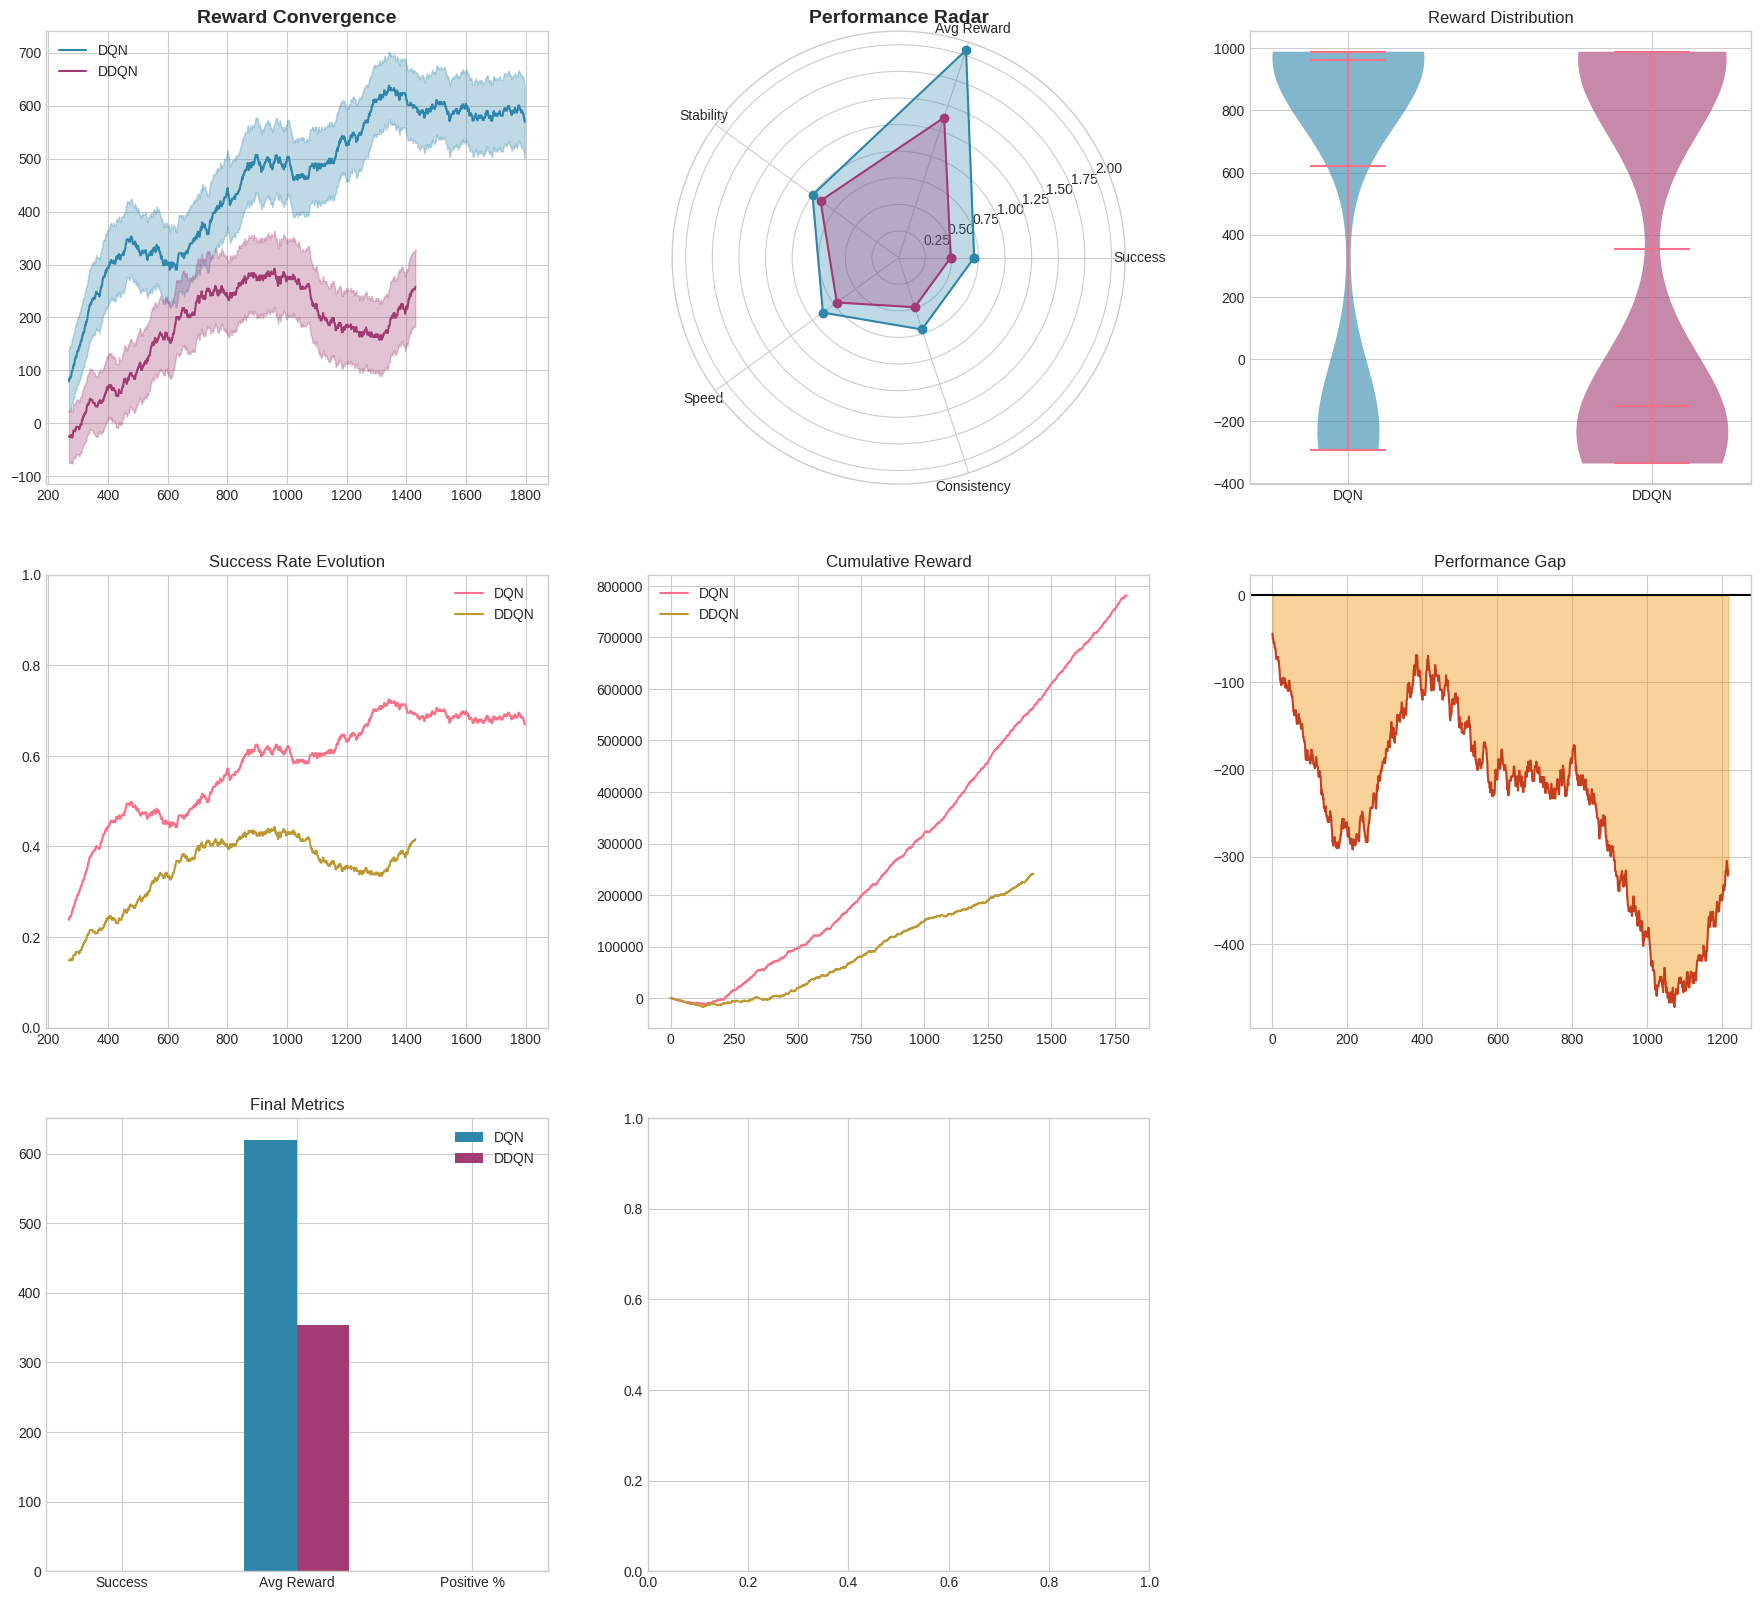

In [10]:
plot_dqn_ddqn_all(
  dqn_rewards, ddqn_rewards,
  dqn_success, ddqn_success,
  dqn_losses, ddqn_losses
)